Epoch [10/100], Loss: 0.001158
Epoch [20/100], Loss: 0.000984
Epoch [30/100], Loss: 0.000801
Epoch [40/100], Loss: 0.000716
Epoch [50/100], Loss: 0.000633
Epoch [60/100], Loss: 0.000571
Epoch [70/100], Loss: 0.000585
Epoch [80/100], Loss: 0.000477
Epoch [90/100], Loss: 0.000558
Epoch [100/100], Loss: 0.000422


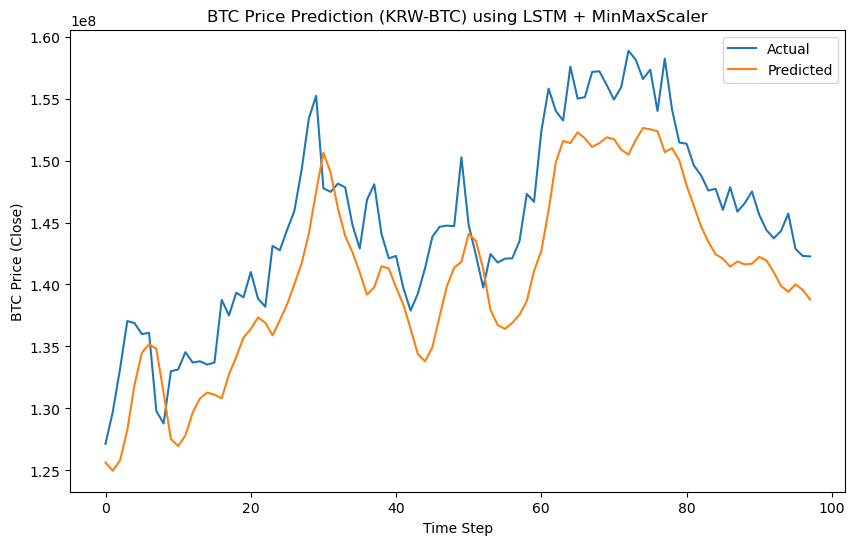

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pyupbit
from sklearn.preprocessing import MinMaxScaler

# 1. Upbit에서 BTC 데이터 다운로드 (KRW-BTC, 일봉 기준)
df = pyupbit.get_ohlcv("KRW-BTC", interval="day", count=500)
if df is None or df.empty:
    raise ValueError("Upbit에서 데이터를 다운로드하지 못했습니다.")

prices = df['close'].values.reshape(-1, 1)  # (N, 1) 형태로 reshape

# 2. MinMaxScaler로 0~1 범위로 정규화
scaler = MinMaxScaler()
prices_scaled = scaler.fit_transform(prices)  # prices를 0~1 범위로 변환

# 3. 시계열 입력 시퀀스(X)와 타깃(y) 생성
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i : i + seq_length]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 10
X, y = create_sequences(prices_scaled, seq_length)

# 학습/테스트 데이터 분할 (8:2)
train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test   = X[train_size:], y[train_size:]

# 4. PyTorch Dataset & DataLoader
class TimeSeriesDataset(Dataset):
    def __init__(self, sequences, targets):
        self.sequences = sequences
        self.targets = targets
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        # (seq_length, 1) 형태 유지
        seq = torch.tensor(self.sequences[idx], dtype=torch.float32)
        target = torch.tensor(self.targets[idx], dtype=torch.float32)
        return seq, target

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset  = TimeSeriesDataset(X_test, y_test)

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 5. LSTM 모델 정의
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc   = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        # x shape: (batch, seq_length, input_size)
        # LSTM의 초기 hidden, cell은 None으로 두면 내부에서 0으로 초기화
        out, (hn, cn) = self.lstm(x)
        # 마지막 타임스텝의 hidden state 사용
        out = out[:, -1, :]
        out = self.fc(out)
        return out

input_size  = 1       # feature 개수 (종가 1개)
hidden_size = 50      # LSTM의 은닉 상태 차원
num_layers  = 1       # LSTM 레이어 수
output_size = 1       # 예측해야 할 값 (다음 종가)

model = LSTMModel(input_size, hidden_size, num_layers, output_size)

# 손실함수, 옵티마이저
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 6. 모델 학습
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    for seq, target in train_loader:
        # seq shape: (batch, seq_length, 1)
        # target shape: (batch, 1)
        optimizer.zero_grad()
        y_pred = model(seq)
        loss = criterion(y_pred, target)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    if (epoch+1) % 10 == 0:
        avg_loss = epoch_loss / len(train_loader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.6f}')

# 7. 테스트 데이터에 대한 예측 수행
model.eval()
predictions_scaled = []
actuals_scaled = []
with torch.no_grad():
    for seq, target in test_loader:
        pred = model(seq)
        predictions_scaled.extend(pred.squeeze().tolist())
        actuals_scaled.extend(target.squeeze().tolist())

# 8. 예측값 & 실제값 역정규화 (스케일링 복원)
predictions_scaled = np.array(predictions_scaled).reshape(-1, 1)
actuals_scaled = np.array(actuals_scaled).reshape(-1, 1)

predictions = scaler.inverse_transform(predictions_scaled)
actuals     = scaler.inverse_transform(actuals_scaled)

# 9. 결과 시각화
plt.figure(figsize=(10, 6))
plt.plot(actuals, label='Actual')
plt.plot(predictions, label='Predicted')
plt.title("BTC Price Prediction (KRW-BTC) using LSTM + MinMaxScaler")
plt.xlabel("Time Step")
plt.ylabel("BTC Price (Close)")
plt.legend()
plt.show()
